In [15]:
import matplotlib.pyplot as plt
from matplotlib import animation
from JSAnimation.IPython_display import display_animation
import numpy as np
import scipy as sp
from scipy import special
from scipy import integrate

In [45]:
time = 100*np.pi # total time in seconds
dt=0.1 # Timestep
nt = int(time / dt) # number of time steps
t0=0; 
theta0=np.pi*0.0; u0 = 0 #Initial time, theta, u
order = 2 # order of symplectic integrator
t=np.linspace(t0,nt*dt,nt) #Iniatialize time array

params = {"k":1.0,"gamma":0.1,"w":1.0,"B":0}

# position update function
def f(theta,u,t,params):
    return u
   
# velocity update function
def g(theta,u,t,params):
    k=params["k"]; gamma=params["gamma"]; w=params["w"]; B=params["B"]
    
    return (gamma*np.cos(w*t) - np.sin(theta))*k**2 - 2*B*u
    #return -theta*k**2 # linear solution

def animateTime(data):
    x = np.linspace(0,time,nt)
    y = data[:-1]
    line.set_data(x,y)
    gamma_text.set_text(r"$\gamma=%.3f$" % data[-1])
    return line,gamma_text

#def animatePhase(data):
#    x = np.linspace(,,)
#    y = data
#    line.set_data(x,y)
#    return line,

In [46]:
# Euler's method (1st order symplectic)
def euler(t,dt,theta0,u0,params):
    theta=np.zeros(t.size)
    u=np.zeros(t.size)
    theta[0]=theta0
    u[0] = u0
    
    for i in range(nt-1):
        u[i+1] = u[i] + dt*g(theta[i],u[i],t[i],params)
        theta[i+1] = theta[i] + dt*f(theta[i],u[i+1],t[i+1],params) # Semi-implicit Euler's method
    return [theta,u]

# Verlet method (2nd order symplectic)
def verlet(t,dt,theta0,u0,params):
    theta=np.zeros(nt)
    u=np.zeros(nt)
    theta[0]=theta0
    u[0] = u0
    for i in range(nt-1):
        theta[i+1] = theta[i] +dt*u[i] + g(theta[i],u[i],t[i],params)*0.5*dt**2 # Semi-implicit Euler's method
        u[i+1] = u[i] + (g(theta[i],u[i],t[i],params)+g(theta[i+1],u[i],t[i+1],params))*0.5*dt
        
    return [theta,u]

# Symplectic integrator
def symplectic(t,dt,theta0,u0,order,params):
    theta=np.zeros(nt)
    u=np.zeros(nt)
    theta[0]=theta0
    u[0] = u0
        
    if (order == 1):
        c = np.array([1, 0, 0, 0])
        d = np.array([1, 0, 0, 0])
    elif (order == 2):
        c = np.array([0, 1, 0, 0])
        d = np.array([0.5, 0.5, 0, 0])
    elif (order == 3):
        c = np.array([1, -2.0/3, 2.0/3, 0])
        d = np.array([-1.0/24, 3.0/4, 7.0/24, 0])
    elif(order == 4):
        x = 2 - 2**(1./3)
        c = np.array([1/(2*x), (1-2**(1./3))/(2*x), (1-2**(1./3))/(2*x), 1/(2*x)])
        d = np.array([1/x, -2**(1/3)/x, 1/x, 0])
    for i in range(nt-1):
        u[i+1] = u[i] + d[0]*dt*g(theta[i],u[i],t[i],params)
        theta[i+1] = theta[i] + c[0]*dt*f(theta[i],u[i+1],t[i+1],params)
        
        u[i+1] = u[i+1] + d[1]*dt*g(theta[i+1],u[i+1],t[i+1],params)
        theta[i+1] = theta[i+1] + c[1]*dt*f(theta[i+1],u[i+1],t[i+1],params)
        
        u[i+1] = u[i+1] + d[2]*dt*g(theta[i+1],u[i+1],t[i+1],params)
        theta[i+1] = theta[i+1] + c[2]*dt*f(theta[i+1],u[i+1],t[i+1],params)
        
        u[i+1] = u[i+1] + d[3]*dt*g(theta[i+1],u[i+1],t[i+1],params)
        theta[i+1] = theta[i+1] + c[3]*dt*f(theta[i+1],u[i+1],t[i+1],params)
    return [theta,u]

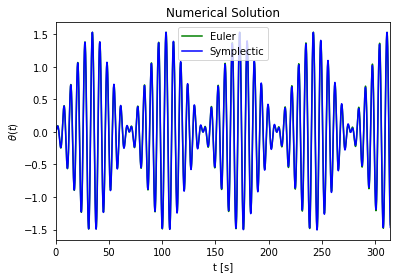

In [47]:
# Solve and plot results

thetaSym,uSym = symplectic(t,dt,theta0,u0,order,params)
thetaEuler,uEuler = euler(t,dt,theta0,u0,params)

plt.plot(t,thetaEuler,label="Euler",color="g")
plt.plot(t,thetaSym,label="Symplectic",color="b")
plt.xlabel('t [s]')
plt.ylabel(r'$\theta(t)$')
plt.xlim(0,dt*nt)
plt.legend()
plt.title("Numerical Solution")
#plt.savefig("figures/drivingForce.png")
#plt.savefig("figures/dampingForce.png")
plt.show()

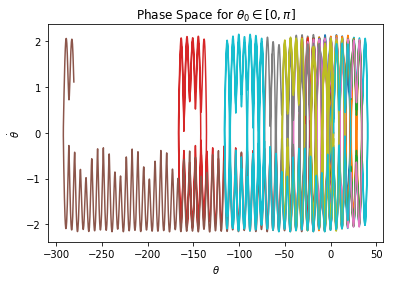

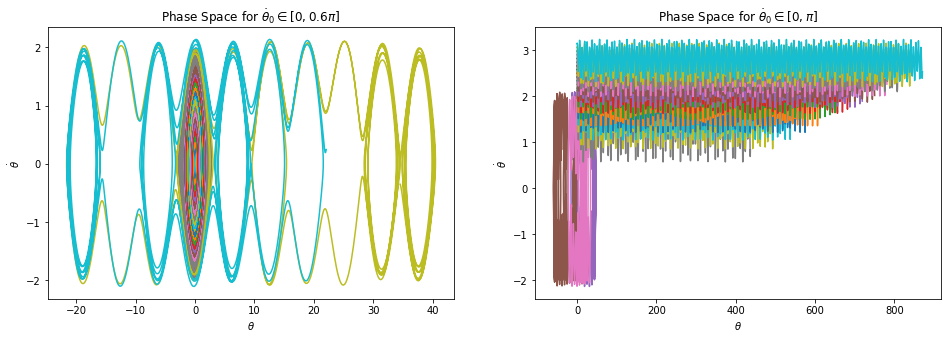

In [48]:
# 1 - Phase space plots
nth = 40 # number of values to run

# Vary theta [0,pi]
theta0s = np.linspace(0,1,nth)*np.pi
u0s = np.zeros(nth)

for i in range(nth):
    thetas,us = symplectic(t,dt,theta0s[i],u0s[i],order,params)
    plt.plot(thetas,us)

plt.xlabel(r'$\theta$')
plt.ylabel(r'$\dot{\theta}$')
plt.title(r'Phase Space for $\theta_{0} \in [0,\pi]$')
#plt.savefig("figures/phaseSpace.png")
plt.show()


# Vary theta_dot
fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)


u0s1 = np.linspace(0,0.63,nth)*np.pi # [0,0.6pi] 
u0s2 = np.linspace(0,1,nth)*np.pi # [0,pi]
theta0s = np.zeros(nth)

for i in range(nth):
    thetas1,us1 = symplectic(t,dt,theta0s[i],u0s1[i],order,params)
    thetas2,us2 = symplectic(t,dt,theta0s[i],u0s2[i],order,params)
    ax1.plot(thetas1,us1)
    ax2.plot(thetas2,us2)
    

ax1.set_xlabel(r'$\theta$')
ax1.set_ylabel(r'$\dot{\theta}$')
ax1.set_title(r'Phase Space for $\dot{\theta}_{0} \in [0,0.6\pi]$')

ax2.set_xlabel(r'$\theta$')
ax2.set_ylabel(r'$\dot{\theta}$')
ax2.set_title(r'Phase Space for $\dot{\theta}_{0} \in [0,\pi]$')
#plt.savefig("figures/phaseSpaceDot.png")
plt.show()
    
#plt.savefig("figures/phaseSpaceDot2.png")
plt.show()

0.0
0.142857142857
0.285714285714
1.42857142857


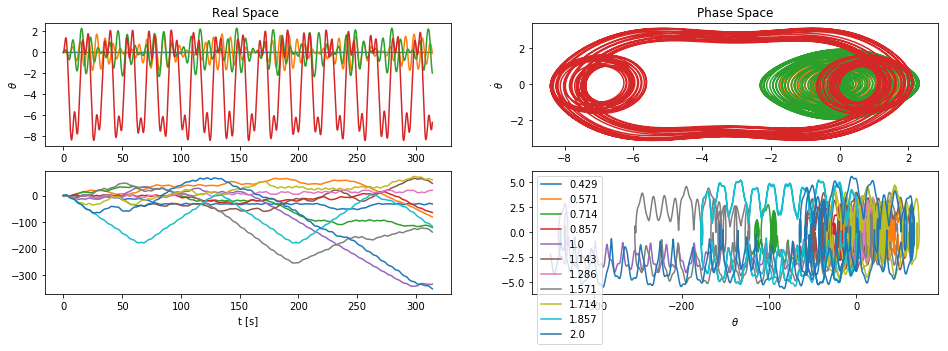


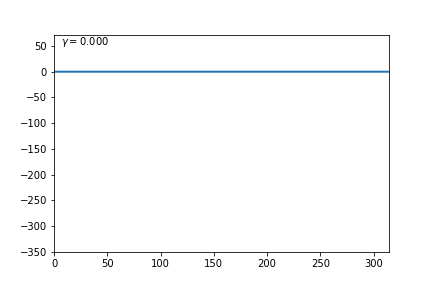
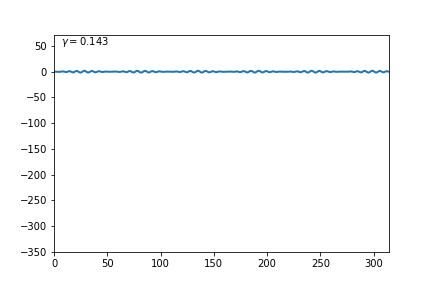
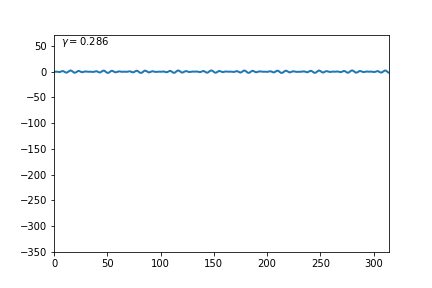
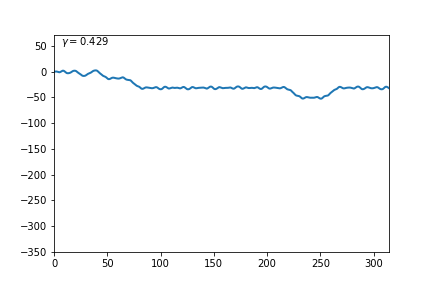
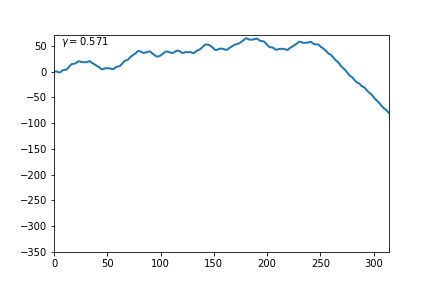
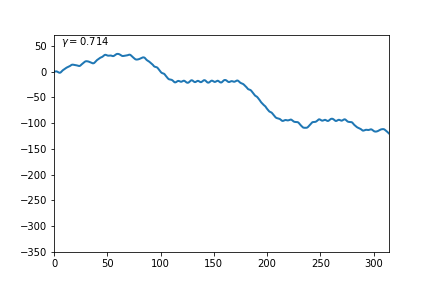
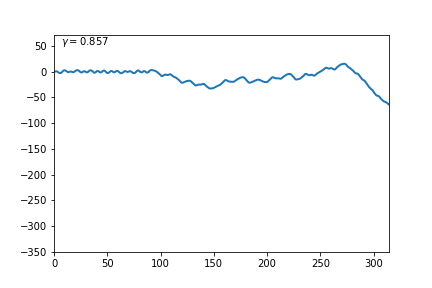
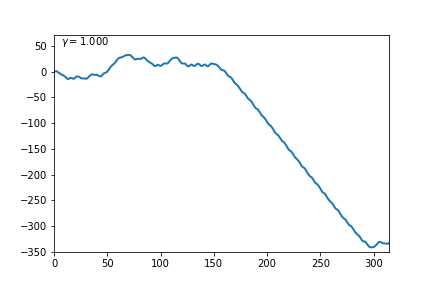
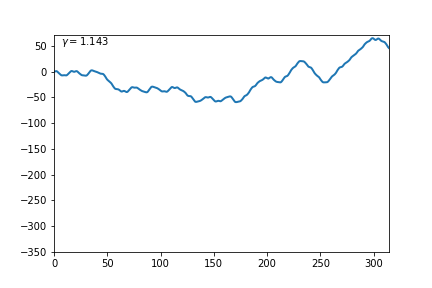
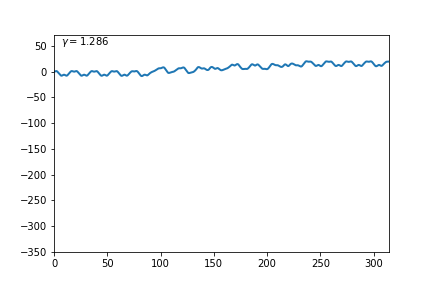
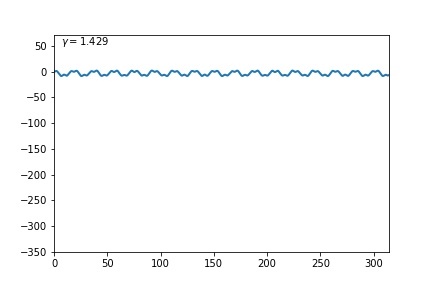
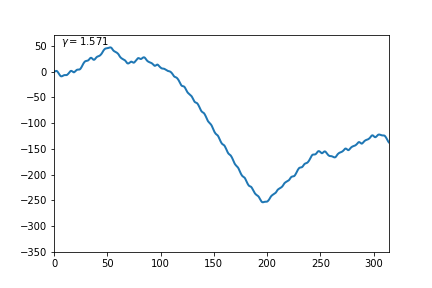
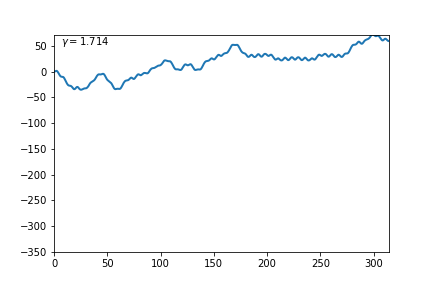
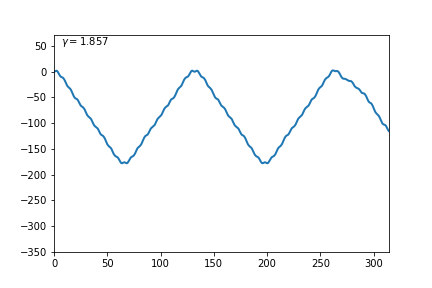
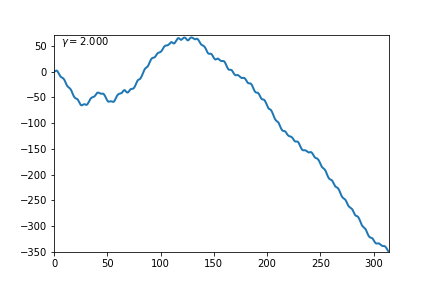

In [51]:
# 4 - Effect of varying gamma

fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

gNum = 15 # number of gamma values
gMax = 2 # maximum gamma value
thMax = 10 # filter non-periodic curves above this

gammas = np.linspace(0,gMax,gNum)

# store all solutions for animation
thetaAll = np.zeros([gammas.size,nt+1])
uAll = np.zeros([gammas.size,nt+1])

# Plot results for all gammas
for i in range(gammas.size):
    params["gamma"] = gammas[i]
    theta,u = symplectic(t,dt,theta0,u0,order,params)
    if np.max(np.abs(theta)) < thMax:
        ax1.plot(t,theta,label=np.around(gammas[i],3))
        ax2.plot(theta,u,label=np.around(gammas[i],3))
        print(params["gamma"])
    else:
        ax3.plot(t,theta,label=np.around(gammas[i],3))
        ax4.plot(theta,u,label=np.around(gammas[i],3))    

    thetaAll[i,:-1] = theta
    uAll[i,:-1] = u

thetaAll[:,-1] = gammas

ax1.set_title("Real Space ")
ax2.set_title("Phase Space")
ax3.set_xlabel("t [s]"); ax1.set_ylabel(r"$\theta$")
ax4.set_xlabel(r"$\theta$"); ax2.set_ylabel(r"$\dot{\theta}$")
plt.legend()
plt.savefig("figures/driving2.pdf",bbox_inches='tight')
plt.show()

# Animate

fig = plt.figure()
ax = plt.axes(xlim=(0,time),ylim=(np.min(np.min(thetaAll)),np.max(np.max(thetaAll))))
line, = ax.plot([],[],lw=2)
gamma_text = ax.text(0.02,0.95,'',transform=ax.transAxes)

animTime = animation.FuncAnimation(fig,animateTime,frames=thetaAll,interval=100)
#animPhase = animation.FuncAnimation(fig,animatePhase,frames=uAll,interval=100)

display_animation(animTime,default_mode='loop')

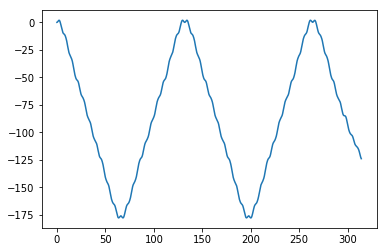

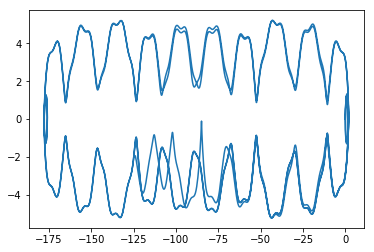

In [50]:
params["gamma"] = 1.857
theta,u = symplectic(t,dt,theta0,u0,order,params)
plt.plot(t,theta,label=np.around(1.857,3))
plt.show()
plt.plot(theta,u,label=np.around(1.857,3))
plt.show()





In [ ]:
# 5 - Identifying (theta0,gamma) pairs for which motion diverges

thMax = np.pi; thNum = 60;
gMax = 6; gNum = 60;
theta0s = np.linspace(0,thMax,thNum)
gammas = np.linspace(0,gMax,gNum)

div = np.zeros([0,3])
progress = 0

for th in theta0s:
    progress += 1
    print(int(100*progress/thNum),end="%\r") #display progress of calculations
    
    for ga in gammas:
        params["gamma"] = ga
        theta,u = symplectic(t,dt,th,u0,order,params)
        if (np.abs(theta[-1]) > np.pi):
            div = np.concatenate((div,np.array([[th,ga,theta[-1]]])))

In [ ]:
# Plotting results

fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(121,xlim=[0,thMax],ylim=[0,gMax])
ax2 = fig.add_subplot(122,xlim=[0,thMax],ylim=[0,gMax])
colormap = plt.cm.Blues

# Colormapped scatter plot
col = np.abs(div[:,2]) # define colors
ax1.scatter(div[:,0],div[:,1],c=col,cmap=colormap,s=25)

# Colormapped contour plot
X = np.linspace(0,thMax,100); Y = np.linspace(0,gMax,100)
Z = plt.mlab.griddata(div[:,0],div[:,1],np.abs(div[:,2]),X,Y,interp='linear')
X,Y = np.meshgrid(X,Y)
ax2.contourf(X,Y,Z,cmap=colormap)

ax1.set_title("Scatter Plot (Actual data)")
ax1.set_xlabel(r"$\theta_{0}$")
ax1.set_ylabel(r"$\gamma$")

ax2.set_title("Contour Plot (Interpolated data)")
ax2.set_xlabel(r"$\theta_{0}$")
ax2.set_ylabel(r"$\gamma$")

plt.savefig("figures/diverge2.png")

plt.show()
# Color corresponds to value of theta at final time

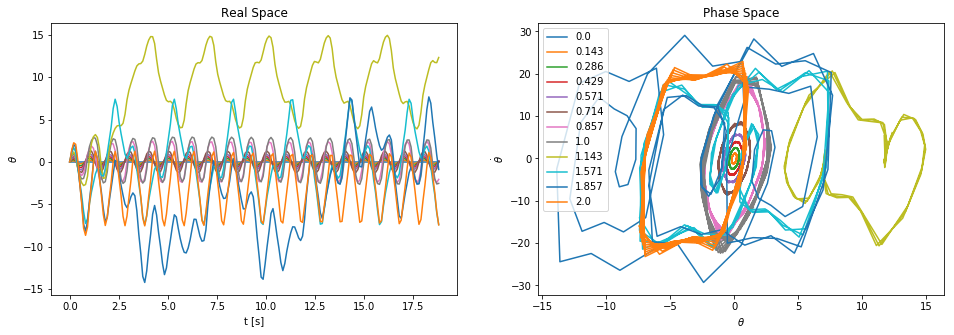

In [20]:
# 6 - Damping, 

params = {"k":3*np.pi,"gamma":0,"w":2*np.pi,"B":0.75*np.pi}
gammas = np.linspace(0,2,15)

fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

thMax = 15

# Plot results for all gammas
for ga in gammas:
    params["gamma"] = ga
    theta,u = symplectic(t,dt,theta0,u0,order,params)
    if (np.max(np.abs(theta)) < thMax):
        ax1.plot(t,theta,label=np.around(ga,3))
        ax2.plot(theta[int(nt/2):],u[int(nt/2):],label=np.around(ga,3))

ax1.set_title("Real Space")
ax2.set_title("Phase Space")
ax1.set_xlabel("t [s]"); ax1.set_ylabel(r"$\theta$")
ax2.set_xlabel(r"$\theta$"); ax2.set_ylabel(r"$\dot{\theta}$")
plt.legend()
plt.savefig('dampedDriven.png', bbox_inches='tight')
plt.show()


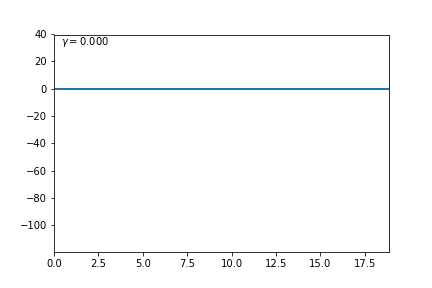
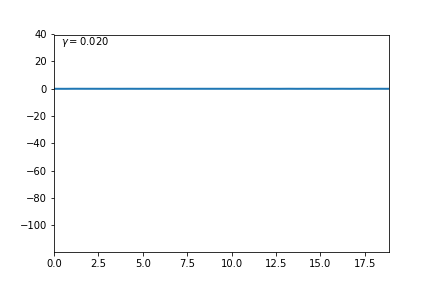
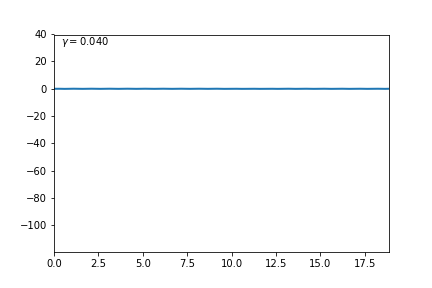
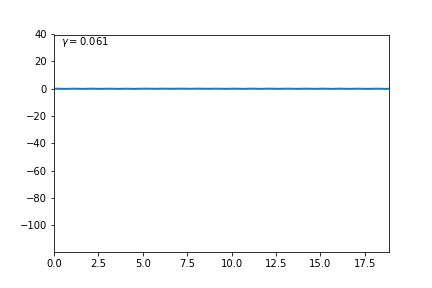
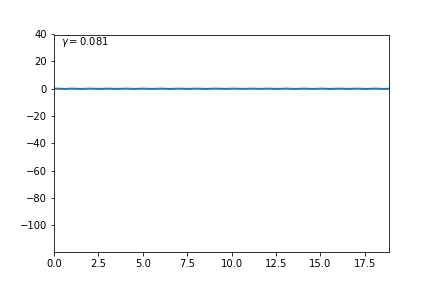
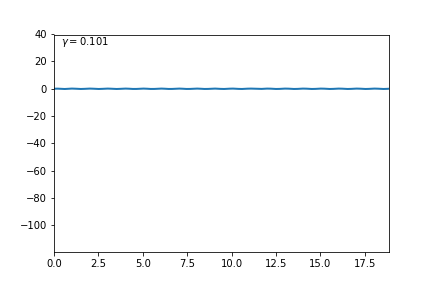
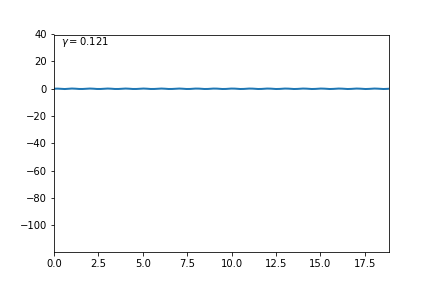
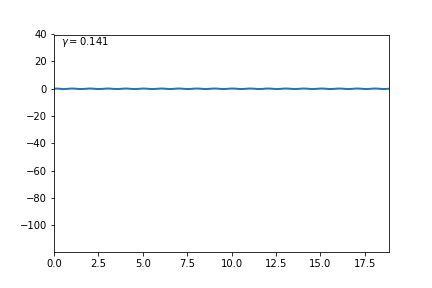
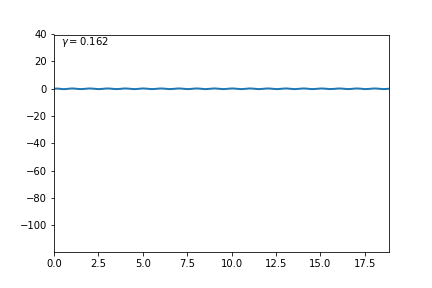
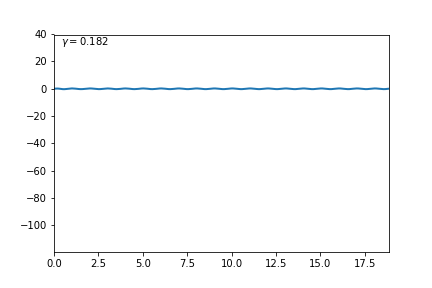
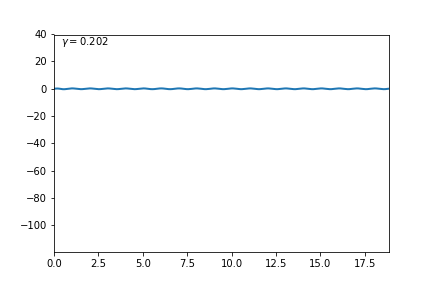
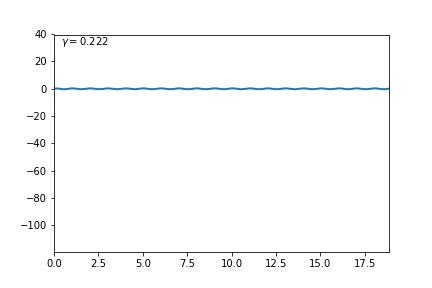
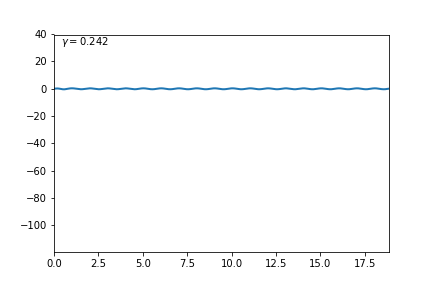
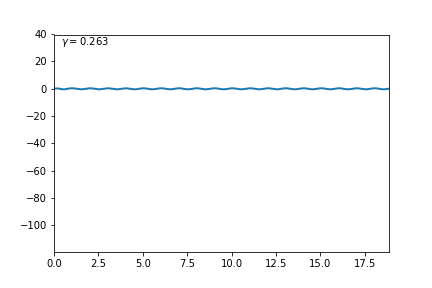
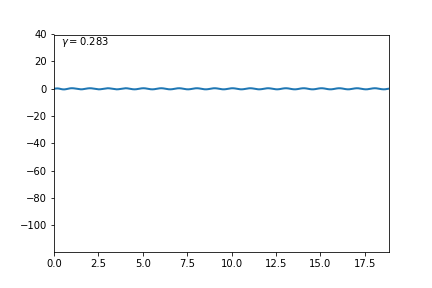
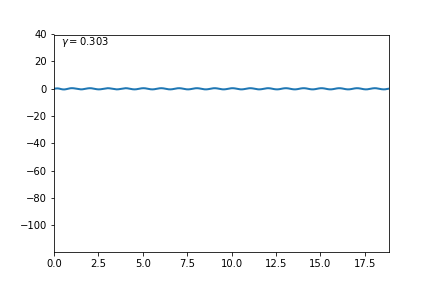
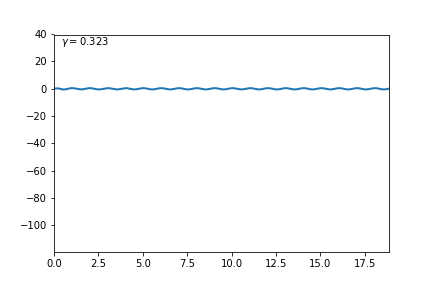
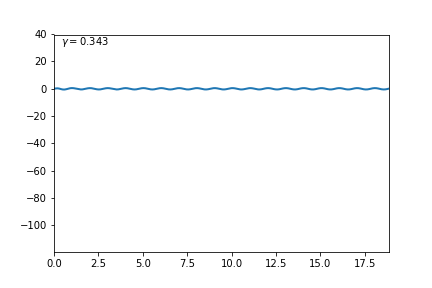
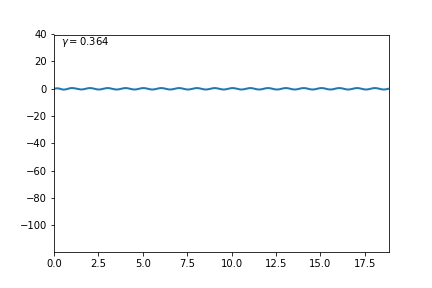
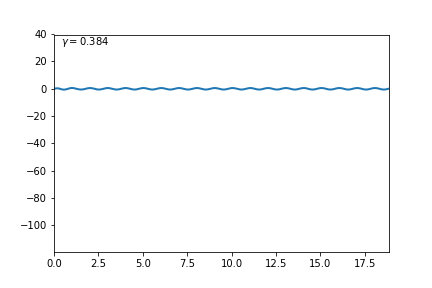
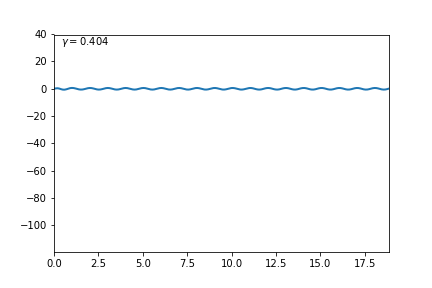
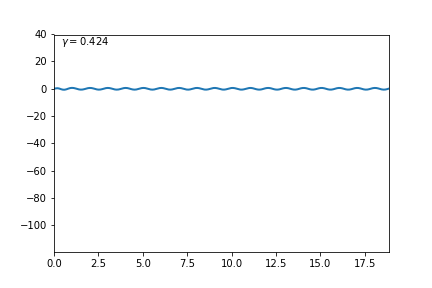
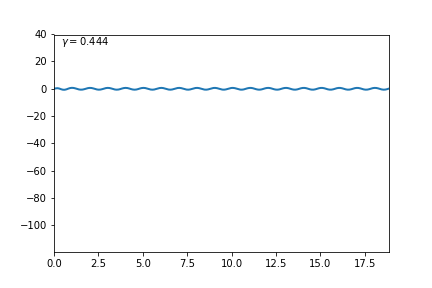
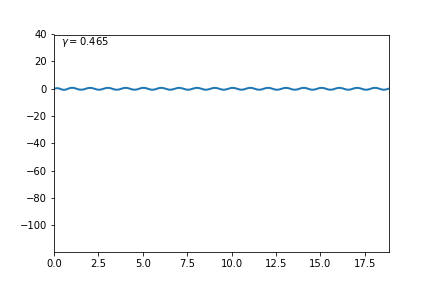
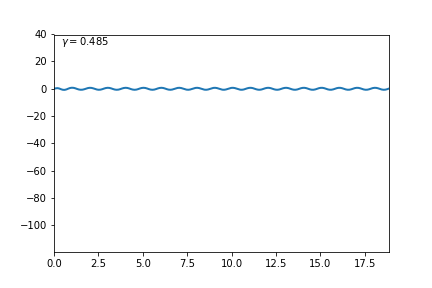
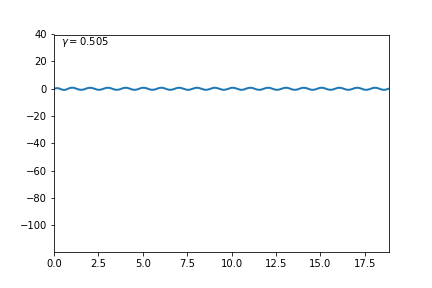
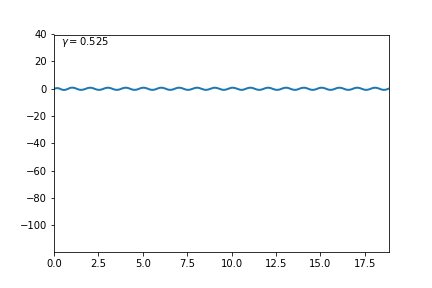
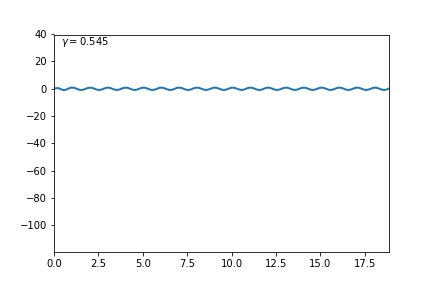
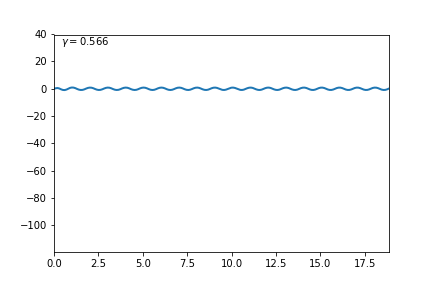
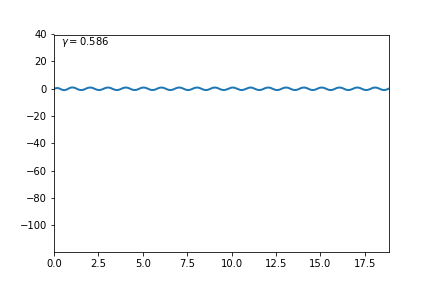
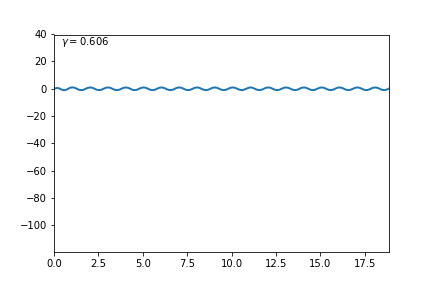
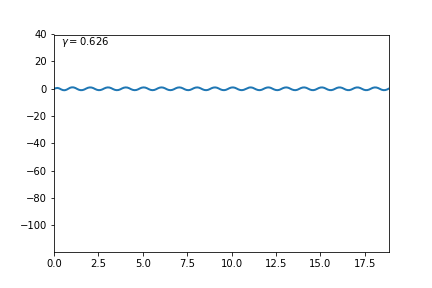
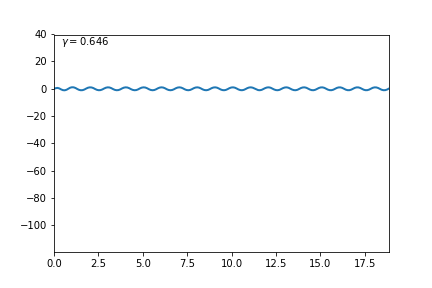
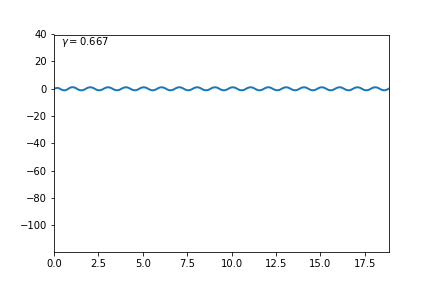
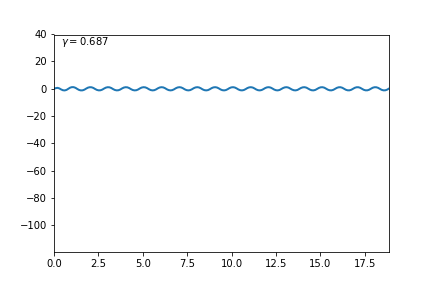
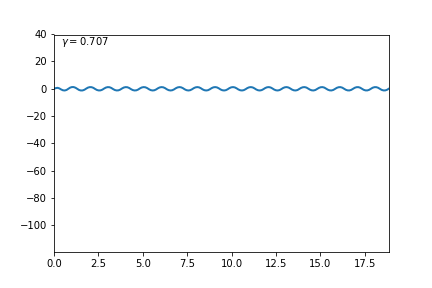
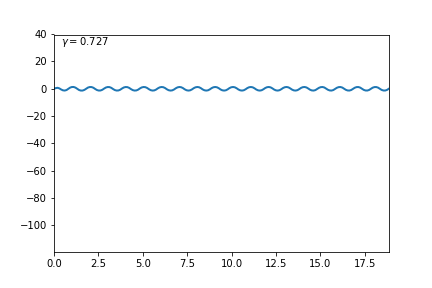
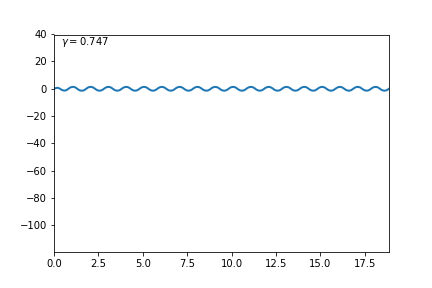
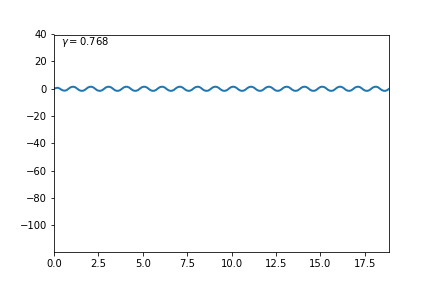
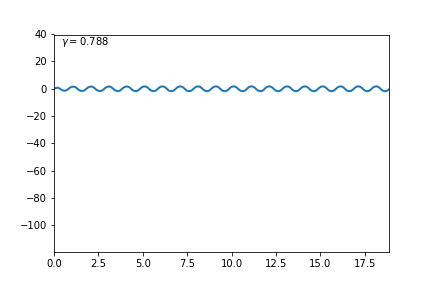
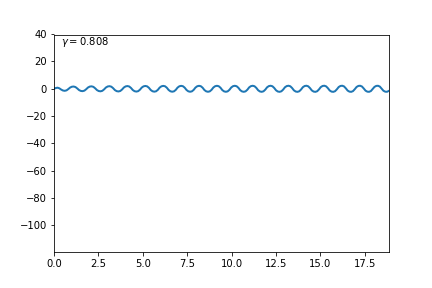
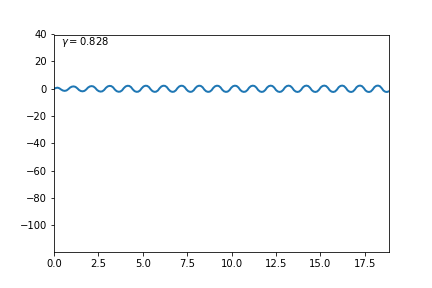
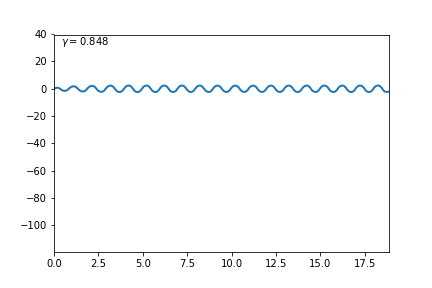
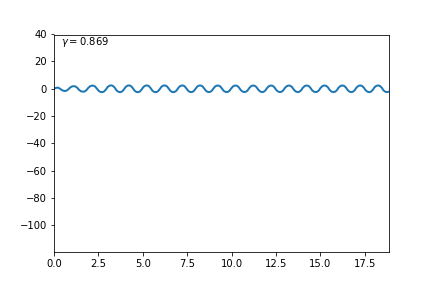
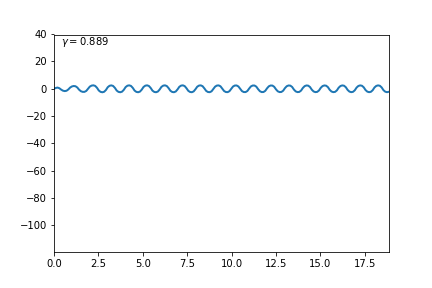
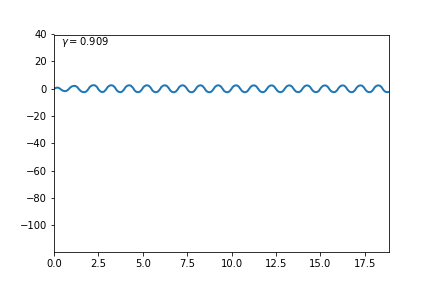
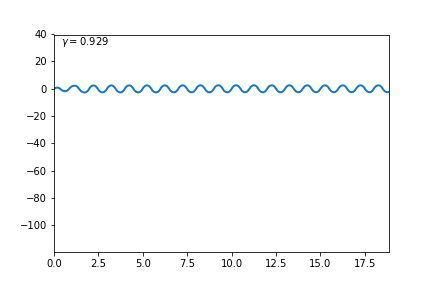
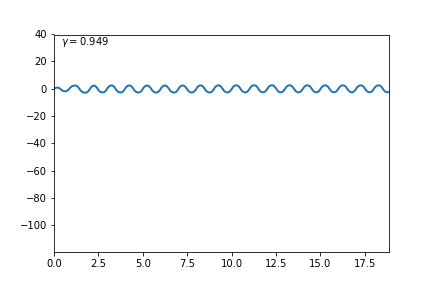
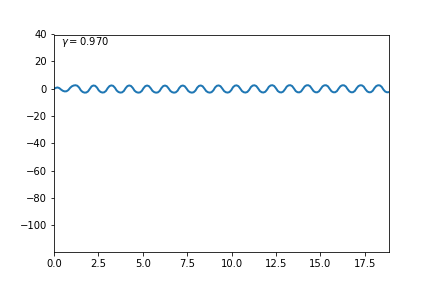
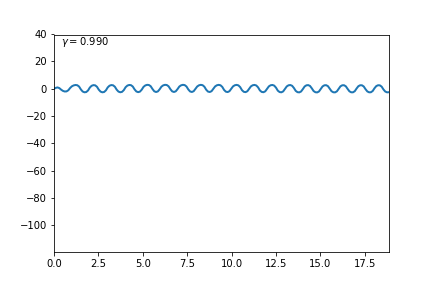
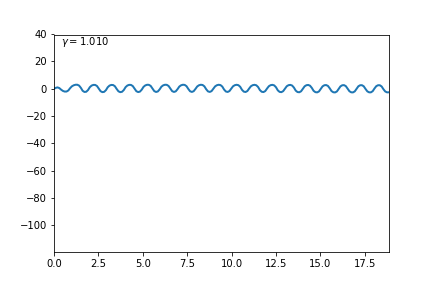
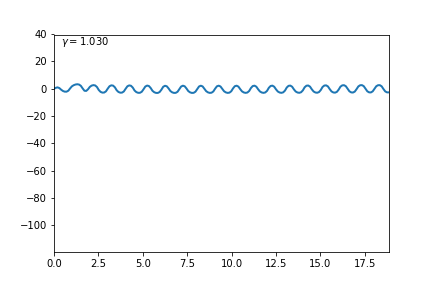
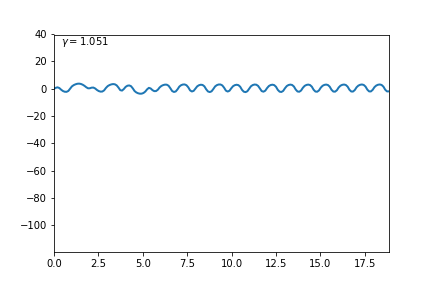
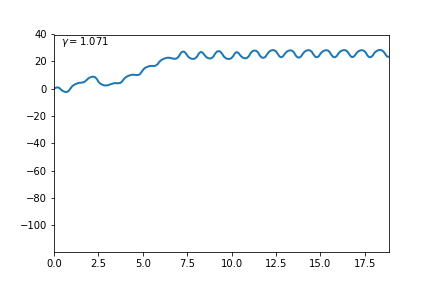
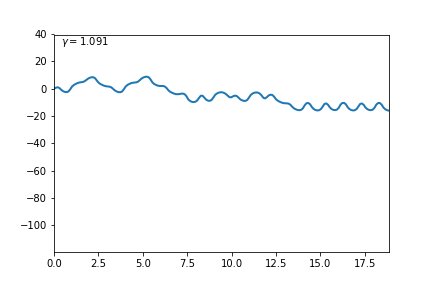
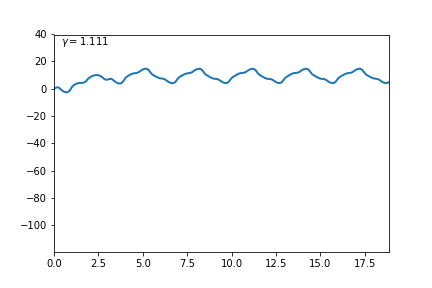
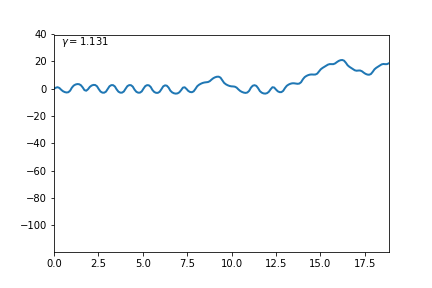
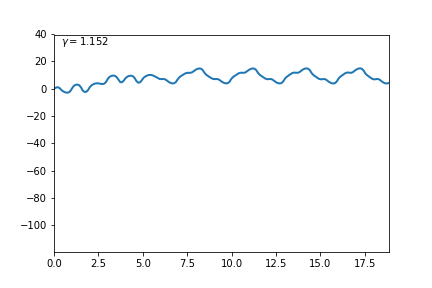
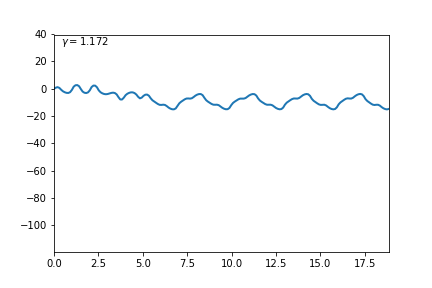
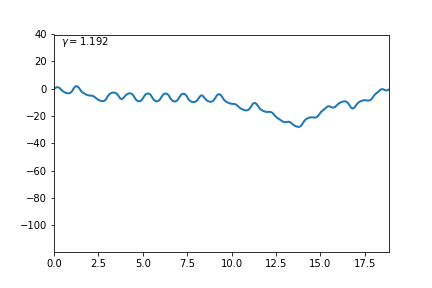
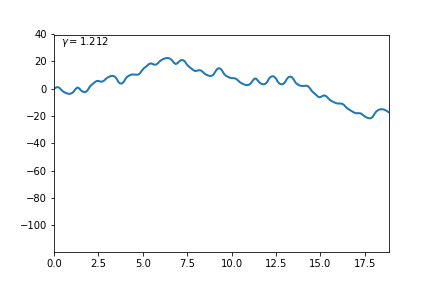
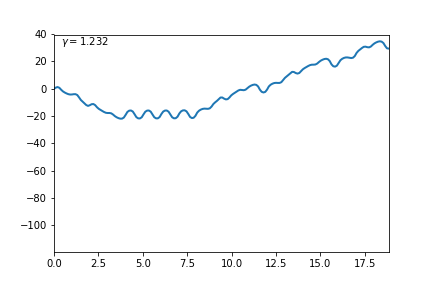
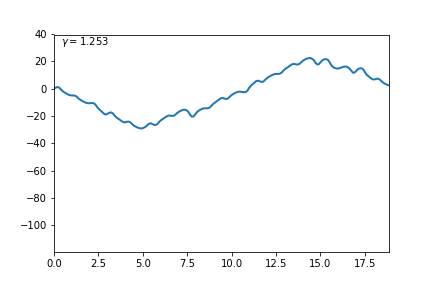
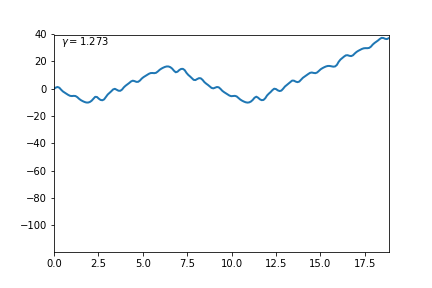
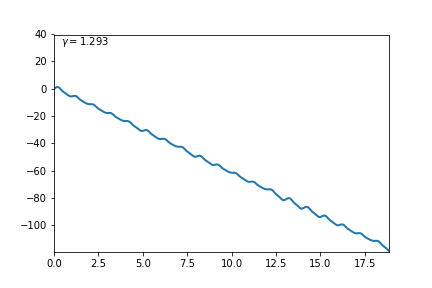
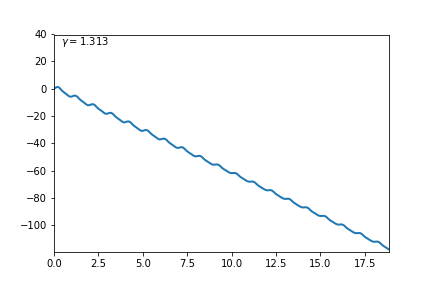
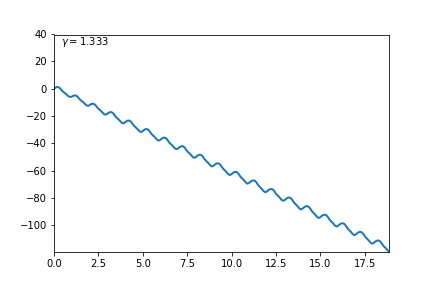
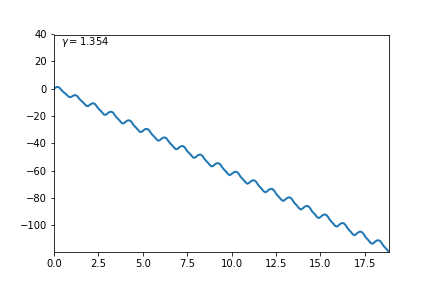
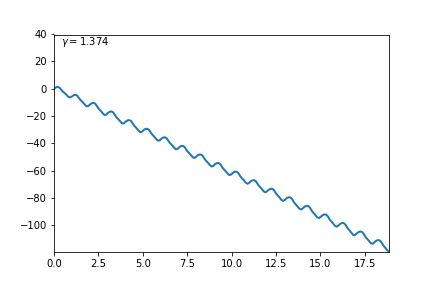
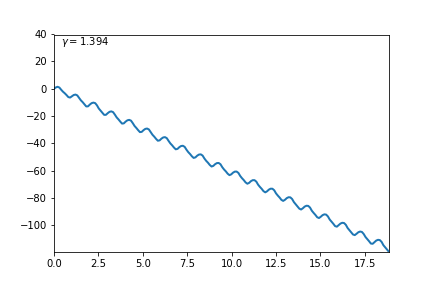
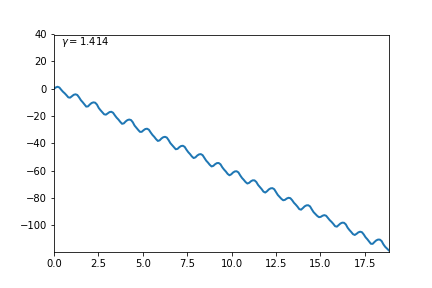
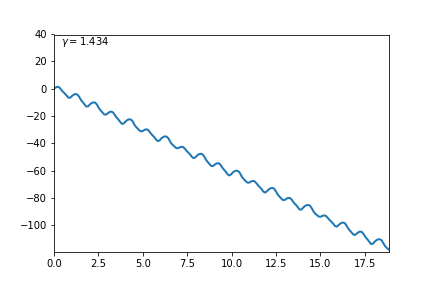
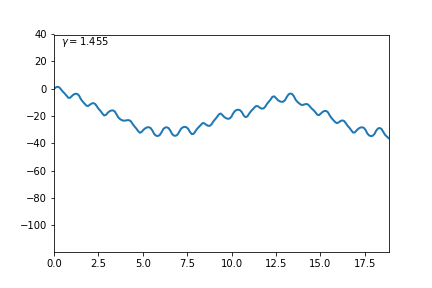
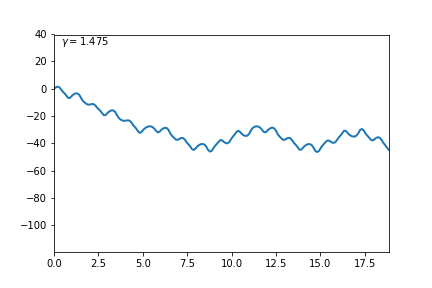
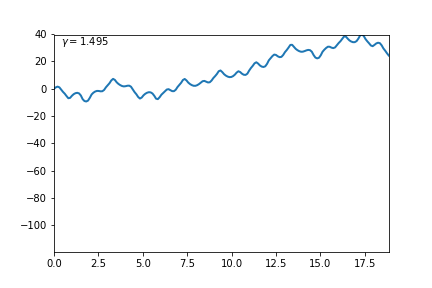
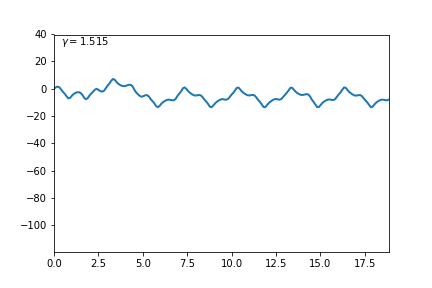
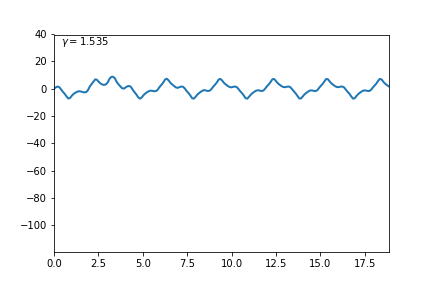
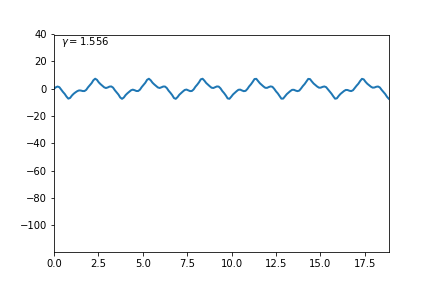
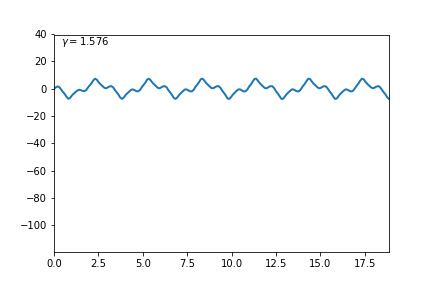
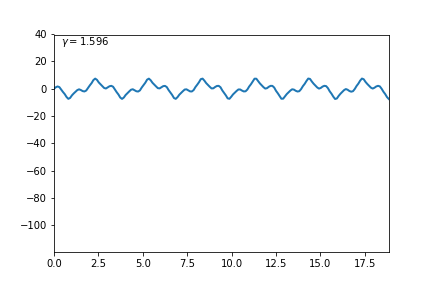
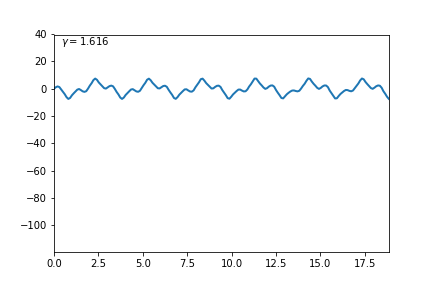
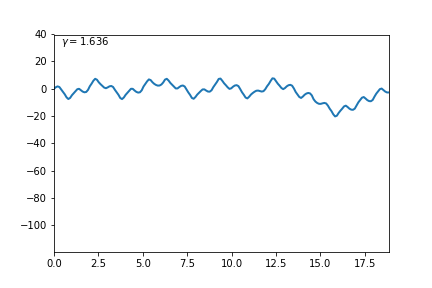
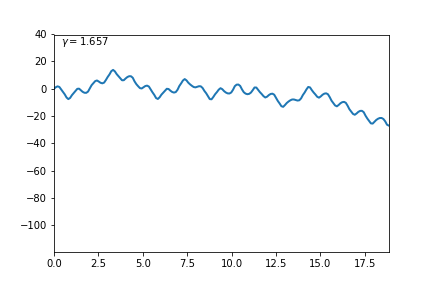
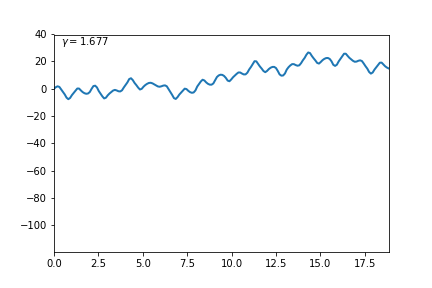
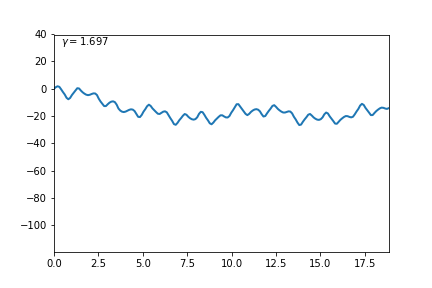
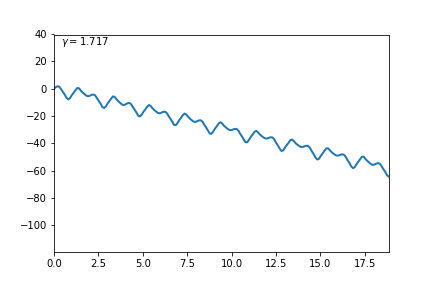
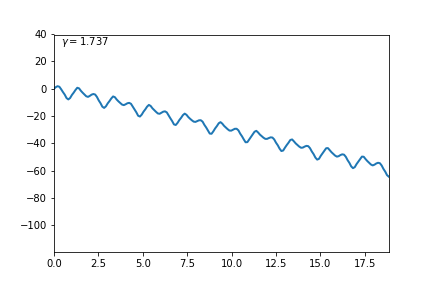
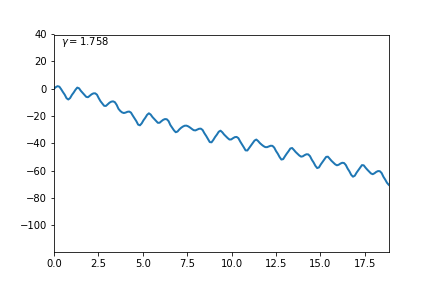
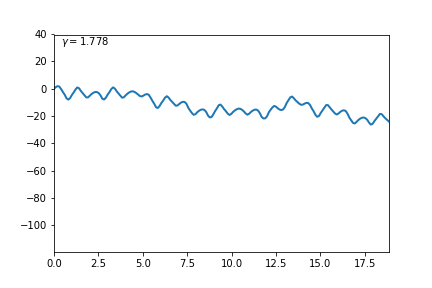
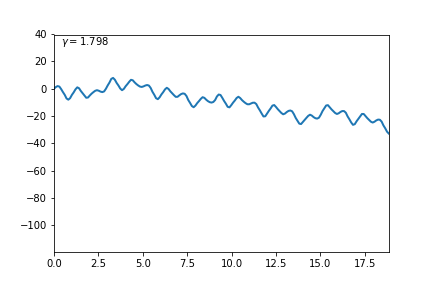
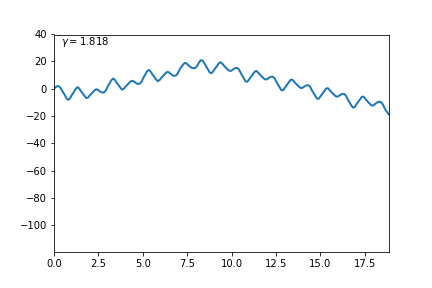
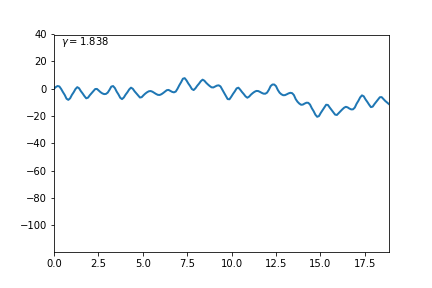
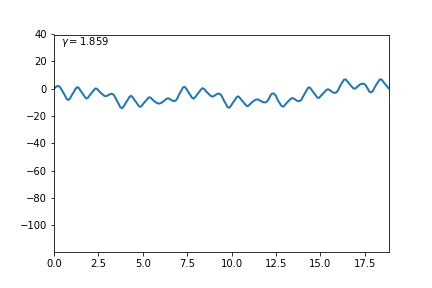
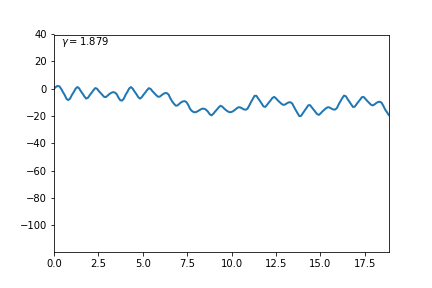
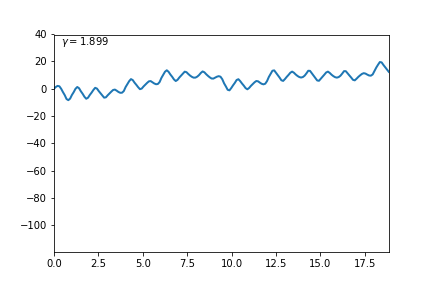
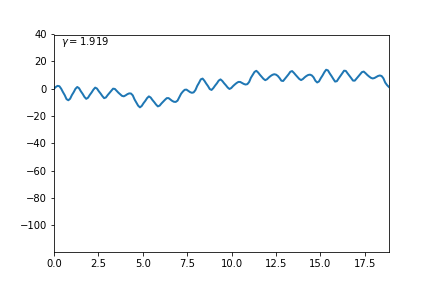
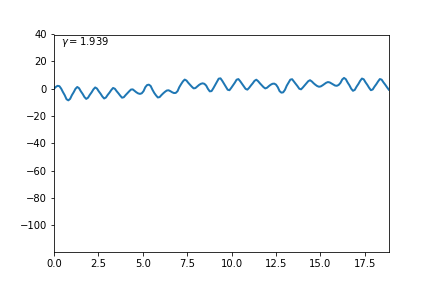
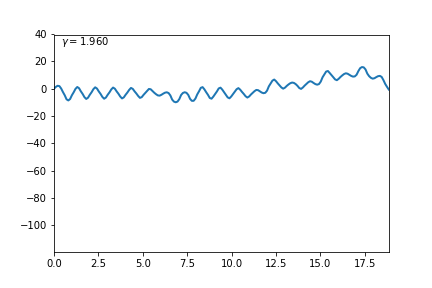
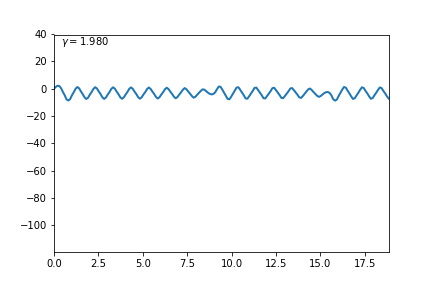
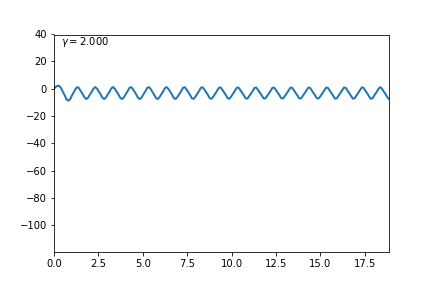

In [1456]:
# Animations (install JSAnimate with "pip3 install git+https://github.com/jakevdp/JSAnimation.git")

params = {"k":3*np.pi,"gamma":0,"w":2*np.pi,"B":0.75*np.pi}
gammas = np.linspace(0,2,100)

thetaAll = np.zeros([gammas.size,nt+1])
uAll = np.zeros([gammas.size,nt+1])

for i in range(gammas.size):
    params["gamma"] = gammas[i]
    thetaAll[i,:-1],uAll[i,:-1] = symplectic(t,dt,theta0,u0,order,params)

thetaAll[:,-1] = gammas
    
fig = plt.figure()
ax = plt.axes(xlim=(0,time),ylim=(np.min(np.min(thetaAll)),np.max(np.max(thetaAll))))
line, = ax.plot([],[],lw=2)
gamma_text = ax.text(0.02,0.95,'',transform=ax.transAxes)

animTime = animation.FuncAnimation(fig,animateTime,frames=thetaAll,interval=100)

display_animation(animTime,default_mode='loop')

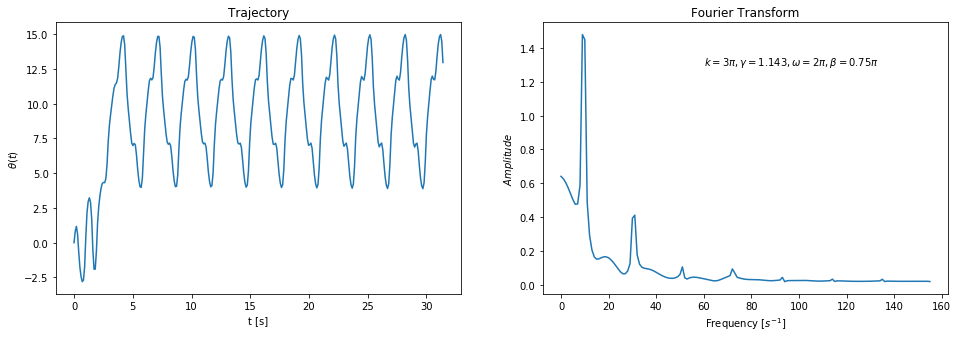

In [58]:
# 7 - Fourier analysis

fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

params = {"k":3*np.pi,"gamma":1.143,"w":2*np.pi,"B":0.75*np.pi}
theta,u = symplectic(t,dt,theta0,u0,order,params)
thetaFT = np.fft.fft(theta)/theta.size
freq = np.fft.fftfreq(nt,dt)

ax1.plot(t,theta)
ax2.plot(np.abs(thetaFT[1:int((nt+1)/2)]))
ax1.set_xlabel(r"t [s]")
ax1.set_ylabel(r"$\theta (t)$")
ax2.set_xlabel(r"Frequency $[s^{-1}]$")
ax2.set_ylabel(r"$Amplitude$")
ax1.set_title("Trajectory")
ax2.set_title("Fourier Transform")
ax2.text(60,1.3,r"$k=3\pi, \gamma=1.143, \omega=2\pi, \beta = 0.75\pi$")
#plt.savefig('figures/fourier.png',bbox_inches='tight')
plt.show()